In [7]:
import numpy as np
import seaborn as sb
from matplotlib import pyplot as plt
import time

import sys, os
sys.path.append(os.path.abspath("/tudelft.net/staff-umbrella/refsetopt/SELECTION_PROJECT/github_final/src"))
import solution.solution_optimized as sol

import importlib
importlib.reload(sol)

<module 'solution.solution_optimized' from '/tudelft.net/staff-umbrella/refsetopt/SELECTION_PROJECT/github_final/src/solution/solution_optimized.py'>

In [2]:
import numpy as np
import random
from scipy.spatial.distance import cdist
import pandas as pd

def generate_data(num_clusters: int, cluster_size: int = 5, random_size: bool = False, lb: int = 1, ub: int = 10, max_dist: float = None, seed: int = 0):
    """
    Generate data on a unit square with a diameter of 1 (i.e. max distance between points is 1). (for now this is not implemented)
    Parameters:
        - num_clusters (int):
            Number of clusters to generate
        - cluster_size (int):
            Number of points in a cluster
        - random_size (bool):
            Set to True if generating randomly sized clusters with size in [1,cluster_size] (inclusive)
        - lb (int):
            Minimal number of points in a cluster
        - ub (int):
            Maximal number of points in a cluster
        - max_dist (float):
            Maximal distance between any pair of points
        - seed (int):
            Seed to use for randomization of points
    Returns:
        - distance_matrix (np.array[np.float32]):
            Distance matrix of all points simulated
        - clusters (list[int]):
            Cluster assignment (every point is assigned a cluster)
    """
    if seed > 0:
        np.random.seed(seed)
        random.seed(seed)
    
    data = []
    clusters = []
    cur_cluster_id = 0
    for _ in range(num_clusters):
        if random_size:
            cluster_size = np.random.randint(lb,ub)
        # Simulate cluster mean
        cur_mean = np.random.rand(2)* min(10, num_clusters) #multiply by #clusters/2 in order to create potentially distinct clusters
        # Simulate cluster shape (covariance matrix)
        cur_std = np.random.rand()*0.3 + 0.2
        cur_cov = np.random.rand()*cur_std - 1e-3
        cur_cov = random.choice([[[cur_std, cur_cov], [cur_cov, cur_std]], [[cur_std, -cur_cov], [-cur_cov, cur_std]]])
        #cur_cov = random.choice([[[2,0],[0,2]], [[1,0],[0,1]], [[2,1],[1,2]], [[1,0.5], [0.5,1]]])
        # Generate points for current cluster and add to data
        cur_points = np.random.multivariate_normal(cur_mean, cur_cov, cluster_size)
        for point in cur_points:
            data.append(point)
            clusters.append(cur_cluster_id)
        cur_cluster_id += 1

    data = np.array(data, dtype=np.float32)
    distances = cdist(data, data, "euclidean")
    # Scale data
    if max_dist:
        scale = max_dist / np.max(distances)
        distances = scale * distances
        data = scale * data
    # Convert to DataFrame
    df = pd.DataFrame(data, columns=["x", "y"])
    df["clusters"] = [str(c) for c in clusters]

    return df, np.array(clusters, dtype=np.int64), np.array(distances, dtype=np.float32)

(887,)
(887, 887)


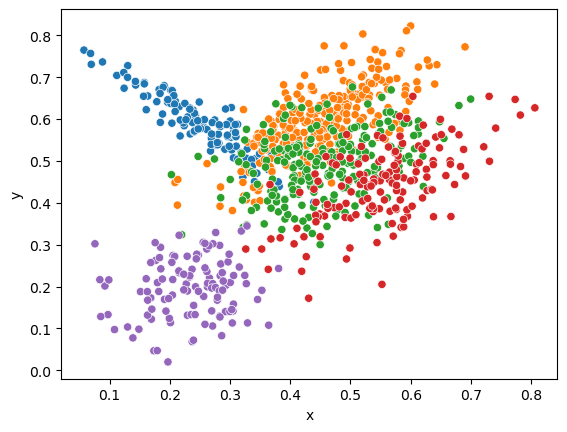

In [8]:
df, clusters, distances = generate_data(num_clusters=5, random_size=True, lb=100, ub=300, max_dist=0.9)
sb.scatterplot(data=df, x="x", y="y", hue="clusters", legend=False)

print(clusters.shape)
print(distances.shape)

In [ ]:
solution_centroid = sol.Solution.generate_centroid_solution(distances, clusters, selection_cost=0.1)
solution_random_10 = sol.Solution.generate_random_solution(distances, clusters, selection_cost=0.1, max_fraction=0.10, seed=1234)
solution_random_25 = sol.Solution.generate_random_solution(distances, clusters, selection_cost=0.1, max_fraction=0.25, seed=12345)
solution_random_50 = sol.Solution.generate_random_solution(distances, clusters, selection_cost=0.1, max_fraction=0.50, seed=123456)
solution_random_75 = sol.Solution.generate_random_solution(distances, clusters, selection_cost=0.1, max_fraction=0.75, seed=1234567)
solution_random_100 = sol.Solution.generate_random_solution(distances, clusters, selection_cost=0.1, max_fraction=1.0, seed=12345678)

print("Instance consists of 1459 points over 50 clusters")
print(f"Centroid objective (cost for selecting = 0.1): {solution_centroid.objective:.5f} with {np.sum(solution_centroid.selection)} selected points")
print(f"Random (10%) objective (cost for selecting = 0.1): {solution_random_10.objective:.5f} with {np.sum(solution_random_10.selection)} selected points")
print(f"Random (25%) objective (cost for selecting = 0.1): {solution_random_25.objective:.5f} with {np.sum(solution_random_25.selection)} selected points")
print(f"Random (50%) objective (cost for selecting = 0.1): {solution_random_50.objective:.5f} with {np.sum(solution_random_50.selection)} selected points")
print(f"Random (75%) objective (cost for selecting = 0.1): {solution_random_75.objective:.5f} with {np.sum(solution_random_75.selection)} selected points")
print(f"Random (100%) objective (cost for selecting = 0.1): {solution_random_100.objective:.5f} with {np.sum(solution_random_100.selection)} selected points")

Instance consists of 1459 points over 50 clusters
Centroid objective (cost for selecting = 0.1): 1253.35933 with 50 selected points
Random (10%) objective (cost for selecting = 0.1): 1327.93176 with 1204 selected points
Random (25%) objective (cost for selecting = 0.1): 1502.39178 with 3012 selected points
Random (50%) objective (cost for selecting = 0.1): 1800.01868 with 6024 selected points
Random (75%) objective (cost for selecting = 0.1): 2099.02914 with 9036 selected points
Random (100%) objective (cost for selecting = 0.1): 2398.64038 with 12048 selected points


In [ ]:
# Solve centroid problem using standard priority
solution_centroid = sol.Solution.generate_centroid_solution(distances, clusters, selection_cost=0.001)
start_time = time.time()
O_centroid, S_centroid = solution_centroid.local_search(max_iterations=500, best_swap=False)
end_time = time.time()
print(f"Local optimum found after {len(O_centroid)-1} iterations: {solution_centroid.objective:.5f} with {np.sum(solution_centroid.selection)} selected points")
print(f"Time elapsed: {end_time - start_time:.2f} seconds")

In [ ]:
# Solve centroid problem focusing on removing first
solution_centroid = sol.Solution.generate_centroid_solution(distances, clusters, selection_cost=0.001)
start_time = time.time()
O_centroid, S_centroid = solution_centroid.local_search_removefirst(max_iterations=2_000, best_swap=False)
end_time = time.time()
print(f"Local optimum found after {len(O_centroid)-1} iterations: {solution_centroid.objective:.5f} with {np.sum(solution_centroid.selection)} selected points")
print(f"Time elapsed: {end_time - start_time:.2f} seconds")

Iteration 200: Objective = 1245.2993528857949
Iteration 400: Objective = 1244.2306098756492
Iteration 600: Objective = 1242.7979260129302
Iteration 800: Objective = 1240.7749330885856
Iteration 1000: Objective = 1238.643831966485
Iteration 1200: Objective = 1236.3993087057454
Iteration 1400: Objective = 1235.2653237964262


KeyboardInterrupt: 

In [ ]:
# Solve centroid problem using random priority
solution_centroid = sol.Solution.generate_centroid_solution(distances, clusters, selection_cost=0.001)
start_time = time.time()
O_centroid, S_centroid = solution_centroid.local_search_random(max_iterations=500)
end_time = time.time()
print(f"Local optimum found after {len(O_centroid)-1} iterations: {solution_centroid.objective:.5f} with {np.sum(solution_centroid.selection)} selected points")
print(f"Time elapsed: {end_time - start_time:.2f} seconds")

In [ ]:
# Solve random 10% problem using standard priority
solution_random_10 = sol.Solution.generate_random_solution(distances, clusters, selection_cost=0.001, max_fraction=0.10, seed=1234)
start_time = time.time()
O_random_10, S_random_10 = solution_random_10.local_search(max_iterations=500, best_swap=False)
end_time = time.time()
print(f"Local optimum found after {len(O_random_10)-1} iterations: {solution_random_10.objective:.5f} with {np.sum(solution_random_10.selection)} selected points")
print(f"Time elapsed: {end_time - start_time:.2f} seconds")

In [ ]:
# Solve random 10% problem focussing on removing first
solution_random_10 = sol.Solution.generate_random_solution(distances, clusters, selection_cost=0.001, max_fraction=0.10, seed=1234)
start_time = time.time()
O_random_10, S_random_10 = solution_random_10.local_search_removefirst(max_iterations=500, best_swap=False)
end_time = time.time()
print(f"Local optimum found after {len(O_random_10)-1} iterations: {solution_random_10.objective:.5f} with {np.sum(solution_random_10.selection)} selected points")
print(f"Time elapsed: {end_time - start_time:.2f} seconds")

In [ ]:
# Solve random 10% problem using random priority
solution_random_10 = sol.Solution.generate_random_solution(distances, clusters, selection_cost=0.001, max_fraction=0.10, seed=1234)
start_time = time.time()
O_random_10, S_random_10 = solution_random_10.local_search_random(max_iterations=500)
end_time = time.time()
print(f"Local optimum found after {len(O_random_10)-1} iterations: {solution_random_10.objective:.5f} with {np.sum(solution_random_10.selection)} selected points")
print(f"Time elapsed: {end_time - start_time:.2f} seconds")

In [ ]:
# Solve random 25% problem using standard priority
solution_random_25 = sol.Solution.generate_random_solution(distances, clusters, selection_cost=0.001, max_fraction=0.25, seed=1234)
start_time = time.time()
O_random_25, S_random_25 = solution_random_25.local_search(max_iterations=500, best_swap=False)
end_time = time.time()
print(f"Local optimum found after {len(O_random_25)-1} iterations: {solution_random_25.objective:.5f} with {np.sum(solution_random_25.selection)} selected points")
print(f"Time elapsed: {end_time - start_time:.2f} seconds")

In [ ]:
# Solve random 25% problem focussing on removing first
solution_random_25 = sol.Solution.generate_random_solution(distances, clusters, selection_cost=0.001, max_fraction=0.25, seed=1234)
start_time = time.time()
O_random_25, S_random_25 = solution_random_25.local_search_removefirst(max_iterations=500, best_swap=False)
end_time = time.time()
print(f"Local optimum found after {len(O_random_25)-1} iterations: {solution_random_25.objective:.5f} with {np.sum(solution_random_25.selection)} selected points")
print(f"Time elapsed: {end_time - start_time:.2f} seconds")

In [ ]:
# Solve random 25% problem focussing on removing first
solution_random_25 = sol.Solution.generate_random_solution(distances, clusters, selection_cost=0.001, max_fraction=0.25, seed=1234)
start_time = time.time()
O_random_25, S_random_25 = solution_random_25.local_search_random(max_iterations=500)
end_time = time.time()
print(f"Local optimum found after {len(O_random_25)-1} iterations: {solution_random_25.objective:.5f} with {np.sum(solution_random_25.selection)} selected points")
print(f"Time elapsed: {end_time - start_time:.2f} seconds")

In [ ]:
# Solve random 100% problem using standard priority
solution_random_100 = sol.Solution.generate_random_solution(distances, clusters, selection_cost=0.001, max_fraction=1.0, seed=1234)
start_time = time.time()
O_random_100, S_random_100 = solution_random_100.local_search_random(max_iterations=5000)
end_time = time.time()
print(f"Local optimum found after {len(O_random_100)-1} iterations: {solution_random_100.objective:.5f} with {np.sum(solution_random_100.selection)} selected points")
print(f"Time elapsed: {end_time - start_time:.2f} seconds")

In [ ]:
import itertools
import numpy as np

# Functions for calculating the groundtruth
def groundtruth_objective_value(selection, clusters, distances, selection_cost):
    inter_normalization = 1 # normalization factor for inter cluster distances
    intra_normalization = 1# normalization factor for intra cluster distances
    # Cost for selecting items
    objective_value = np.sum(selection) * selection_cost
    print("Selection cost:", objective_value)
    # Intra cluster costs
    cur = 0
    for idx in np.where(~selection)[0]:
        cur_min = np.inf
        for other_idx in np.where((clusters == clusters[idx]) & selection)[0]:
            cur_min = min(cur_min, distances[idx, other_idx])
        objective_value += cur_min / intra_normalization
        cur += cur_min / intra_normalization
    print("Intra cluster cost:", cur)
    # Inter cluster costs
    cur = 0
    unique_clusters = np.unique(clusters)
    for cluster_pair in itertools.combinations(unique_clusters, 2):
        cluster_1 = np.where((clusters == cluster_pair[0]) & selection)[0]
        cluster_2 = np.where((clusters == cluster_pair[1]) & selection)[0]
        cur_max = -np.inf
        for point_pair in itertools.product(cluster_1, cluster_2):
            cur_max = max(cur_max, 1 - distances[point_pair[0], point_pair[1]])
        objective_value += cur_max / inter_normalization
        cur += cur_max / inter_normalization
    print("Inter cluster cost:", cur)
    return objective_value

In [ ]:
print("Centroid")
print("Total cost:", groundtruth_objective_value(solution_centroid.selection, clusters, distances, selection_cost=0.1))
print("Random 10%")
print("Total cost:", groundtruth_objective_value(solution_random_10.selection, clusters, distances, selection_cost=0.1))
print("Random 25%")
print("Total cost:", groundtruth_objective_value(solution_random_25.selection, clusters, distances, selection_cost=0.1))

In [ ]:
from pympler import asizeof
from scipy.spatial.distance import squareform
import time

distances_condensed = squareform(distances)

def convert(i, j, n):
    if i == j:
        return -1
    elif i > j:
        i, j = j, i
    return n * i - (i * (i + 1) // 2) + j - i - 1

def find_distance(i, j, n, distances_condensed):
    index = convert(i, j, n)
    if index == -1:
        return 0.0
    else:
        return distances_condensed[index]

i = random.randint(0, distances.shape[0]-1)
j = random.randint(0, distances.shape[0]-1)

t = time.time()
print(distances[i, j], time.time() - t)
t = time.time()
print(find_distance(i, j, distances.shape[0], distances_condensed), time.time() - t)


solution_centroid = sol.Solution.generate_centroid_solution(distances, clusters, selection_cost=0.1)
t = time.time()
print(solution_centroid.get_distance(i, j), time.time() - t)

print(asizeof.asizeof(solution_centroid) / 1024**3)


0.09209297 6.937980651855469e-05
0.09209297 7.677078247070312e-05
0.09209297 0.00010156631469726562
0.0005774796009063721


In [ ]:
N = 500
# adding
t = time.time()
for _ in range(N):
    a, b, c = solution_centroid.evaluate_add(0)
t_end = time.time()
print(f"Time elapsed for {N} evaluations: {t_end - t:.4f}s, average runtime: {1000*(t_end - t)/N:.4f}ms")

# swapping
t = time.time()
for _ in range(N):
    a, b, c = solution_centroid.evaluate_swap(0, 63)
t_end = time.time()
print(f"Time elapsed for {N} evaluations: {t_end - t:.4f}s, average runtime: {1000*(t_end - t)/N:.4f}ms")

# swapping
t = time.time()
for _ in range(N):
    a, b, c = solution_centroid.evaluate_doubleswap((0, 1), 63)
t_end = time.time()
print(f"Time elapsed for {N} evaluations: {t_end - t:.4f}s, average runtime: {1000*(t_end - t)/N:.4f}ms")

Time elapsed for 500 evaluations: 0.0509s, average runtime: 0.1019ms


ValueError: The point to add must not be selected and the point to remove must be selected.

In [ ]:
solution_centroid.selection[:64]

In [ ]:
import time

# Solve centroid problem parallel
solution_centroid = sol.Solution.generate_centroid_solution(distances, clusters, selection_cost=0.001)
start_time = time.time()
solution_centroid.local_search_parallel(max_iterations=500, num_cores=4)
end_time = time.time()
print("Time spent on parallel local search:", end_time - start_time)

# Solve centroid problem single core
solution_centroid = sol.Solution.generate_centroid_solution(distances, clusters, selection_cost=0.001)
start_time = time.time()
O_centroid, S_centroid = solution_centroid.local_search(max_iterations=500)
end_time = time.time()
print("Time spent on single core local search:", end_time - start_time)


Accepting new solution in iteration 0
Accepting new solution in iteration 1
Accepting new solution in iteration 2
Accepting new solution in iteration 3
Accepting new solution in iteration 4
Accepting new solution in iteration 5
Accepting new solution in iteration 6
Accepting new solution in iteration 7
Accepting new solution in iteration 8
Accepting new solution in iteration 9
Accepting new solution in iteration 10
Accepting new solution in iteration 11
Accepting new solution in iteration 12
Accepting new solution in iteration 13
Accepting new solution in iteration 14
Accepting new solution in iteration 15
Accepting new solution in iteration 16
Accepting new solution in iteration 17
Accepting new solution in iteration 18
Accepting new solution in iteration 19
Accepting new solution in iteration 20
Accepting new solution in iteration 21
Accepting new solution in iteration 22
Accepting new solution in iteration 23
Accepting new solution in iteration 24
Accepting new solution in iteration